# k-NN model to classify the CIFAR10 data set

In this first tutorial, we will get started with image classification. We will work with a classical (but difficult) data set named CIFAR10. it is composed of 60000 images with 10 classes. The goal is to train a classifier which is able to assign the correct class when presented with an image it did not see before.

For this first tutorial, we will program k-NN classification and compare our results with the `sklearn` library. The goal is to get familiar with manipulating image data and image classification. In the next tutorials we will tackle more competitive methods.

**NB:** To work through this notebook, you will have to execture cells (Shift + Return) after **filling in the code where `...` are located**. These are the places you need to work on. Read all the comments above the cells, they are useful!

## Prepare and get a sense of the data

We start by loading our image data set: CIFAR10. Do this by using the metho `cifar10.load_data`. This will directly give you the data in form of `numpy` arrays and partitioned into train and test data.

Observe the shape of the data points: they are in 8 bits RGB image form $32\times 32 \times3$. In this case the number of features is $d=3072$.

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of train data is {}, type is {}'.format(x_train.shape, x_train.dtype))
print('shape of test data is {}, type is {}'.format(x_test.shape, x_test.dtype))

170500096/170498071 [==============================] - 2s 0us/step
shape of train data is (50000, 32, 32, 3), type is uint8
shape of test data is (10000, 32, 32, 3), type is uint8


Plot an image using matplotlib. The function `imshow` automatically interpret the third dimension of the image as the RGB channels.

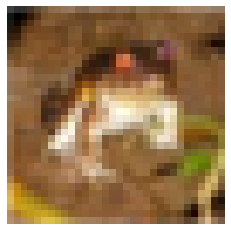

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(x_train[0])
plt.axis('off')
plt.show()

Plot the first 100 image in a 10 x 10 grid to get a sense of the data

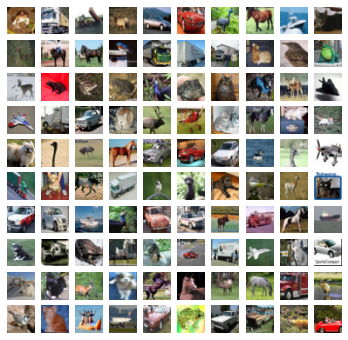

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(10):
    for j in range(10):
        index = 10 * j + i
        axi = plt.subplot(10, 10, index + 1)
        axi.imshow(x_train[index])
        axi.axis('off')
plt.show()

The `y_train` vector corresponds to one of the 10 class ids. observe the class ids usinque the `np.unique` function of `numpy`.

In [ ]:
import numpy as np

print(np.unique(y_train))
print(y_train[:5])

[0 1 2 3 4 5 6 7 8 9]
[[6]
 [9]
 [9]
 [4]
 [1]]


In [ ]:
np.where(y_train == 1)[0][:10]

array([ 4,  5, 32, 44, 45, 46, 60, 61, 64, 65])

Define a list representing the image categories: 

In [ ]:
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'boat', 'truck']

Now we know how to manipulate our data, let's display the first 10 images of each class in the training set. For this we will use the same sort of code as before for plotting images on a grid, but we have to search the right indices of the images so they belong to the right class.

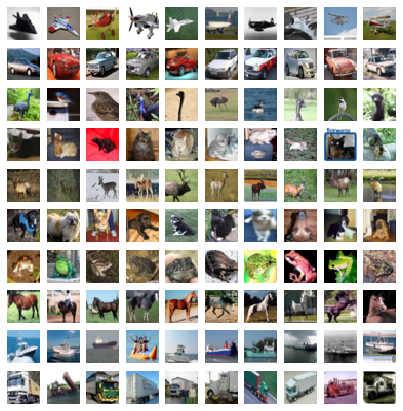

In [ ]:
n = 10
plt.figure(figsize=(6, 6))
for j in range(n):
    for i in range(n):
        axi = plt.subplot(n, n, n * j + (1 + i))
        index_class_j = np.where(y_train == j)[0][i]
        axi.imshow(x_train[index_class_j, :, :, :])
        axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

## Model definition: distance between data points

k-Nearest-Neighbors (k-NN): the simplest machine learning algorithm (does not actually learn anything): classifies unknown data points by finding the  most common class among the $k$ closest examples ($k$ is odd).

The distance between data points need to be defined. Classical examples:

 - Manhattan distance $\sum_{i=1}^d|A_i - B_i|$
 - Euclidean distance $\sqrt{\sum_{i=1}^d(A_i - B_i)^2}$


Start by computing both Euclidean and Manhattan distances between the first two images. Be careful to set the data type to signed integer (use `int16`)

In [ ]:
A = x_train[0].astype(np.int16)
B = x_train[1].astype(np.int16)
print('data type should be int16, got: %s' % A.dtype)

d1 = np.sum(abs(A - B))
print('Manhattan distance: {}'.format(d1))

d2 = np.sqrt(np.sum((A - B) ** 2))
print('Euclidean distance: {}'.format(d2))

data type should be int16, got: int16
Manhattan distance: 197173
Euclidean distance: 3837.1052891470154


In [ ]:
print(A[0, 0, 0], B[0, 0, 0])
print((A - B)[0, 0, 0])

59 154
-95


Now prepare for training the NN-model.

First we reshape the data into large column vectors `X_train` and `X_test`. Use the function `np.reshape` for this. Note that both vectors must be of type signed integers (eg `np.int16`) to avoid problems with uint8 when computing L1 distance.

In [ ]:
X_train = x_train.reshape((50000, -1)).astype(np.int16)
X_test = x_test.reshape(x_test.shape[0], -1).astype(np.int16)

print('shape of train data is {}, type is {}'.format(X_train.shape, X_train.dtype))
print('shape of test data is {}, type is {}'.format(X_test.shape, X_test.dtype))

shape of train data is (50000, 3072), type is int16
shape of test data is (10000, 3072), type is int16


## Run the model with k=1

Use L1 (Manhattan) distance to compare images and perform nearest neighbor prediction on a **random image of the test set**. Note that in the case of k-NN we can use image in the test set since the model is not actually learning any parameters.

Compute the L1 distance of a random image with the **first 10 images of the training set**.

In [ ]:
index = np.random.randint(X_test.shape[0])
print('using image {}'.format(index))

image = X_test[index]
print(image.shape)
print(X_train[:10, :].shape)
d1 = np.sum(np.abs(image - X_train[:10, :]), axis=1)
print(d1)

using image 4000
(3072,)
(10, 3072)
[180026 192861 222985 196371 201943 214115 176959 175956 181933 213650]


Here we pick a category $k=5$ (dog). Get the first dog image in the test set and compute all $d_1$ distances (with all images in the training set). Then **make a prediction** for this image.

In [ ]:
k = 5
# pick the first test image with category k
index_for_k = np.where(y_test == k)[0][0]
print('index of %s image being tested: %d' % (labels[k], index_for_k))
print(y_test[index_for_k])  # should be equal to [k]
image = x_test[index_for_k].astype(np.int16)

# compute all d1 distances
all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
min_index = all_d1.argmin()
print('min_index = %d' % min_index)
sorted_indices = np.argsort(all_d1)[:10]
print(sorted_indices)
print(all_d1[sorted_indices])
category = np.squeeze(y_train[min_index])

print('predicted class is %d' % category)
print('actual class is %d' % k)

index of dog image being tested: 12
[5]
min_index = 8398
[ 8398  3540  4124 35992  9762  2745 20501 45290 17939 46423]
[107143 107923 108278 109439 109979 110250 110627 111004 111232 111667]
predicted class is 5
actual class is 5


Plot the test image and the nearest neighbor image in the training set.

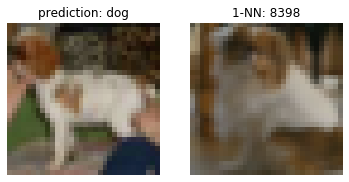

In [ ]:
ax = plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('prediction: %s' % labels[category])
# now display the first NN
ax = plt.subplot(1, 2, 2)
plt.imshow(x_train[min_index])
plt.axis('off')
plt.title('1-NN: %s' % min_index)
plt.show()

Create a vertical representation of the 10 image classes using the first one of each class in the test set.

In [ ]:
n = 10
plt.figure(figsize=(1, 5.8))
for k in range(n):
    index_for_k = ...
    axi = plt.subplot(n, 1, k + 1)
    axi.imshow(...)
    axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

Display the first 10 nearest neighbors of each test image

In [ ]:
n = 10
plt.figure(figsize=(5.8, 5.8))  # (3.4, 3.4) for n = 6
for k in range(n):
    index_for_k = k
    image = x_test[index_for_k].astype(np.int16)
    all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
    sorted_indices = np.argsort(all_d1)[:10]
    for i in range(n):
        axi = plt.subplot(n, n, n * k + (1 + i))
        axi.imshow(x_train[sorted_indices[i]])
        axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

Create a visual representation of the pattern by averaging the first 10 NN

In [ ]:
n = 10
plt.figure(figsize=(1, 5.8))  # (3.4, 3.4) for n = 6
for k in range(n):
    index_for_k = np.where(y_test == k)[0][3]
    image = x_test[index_for_k].astype(np.int16)
    all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
    sorted_indices = np.argsort(all_d1)[:100]
    # average the NN
    pattern = np.mean(x_train[sorted_indices], axis=0).astype(np.uint8)
    axi = plt.subplot(n, 1, k + 1)
    axi.imshow(pattern)
    axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

## Use sklearn to perform 1-NN classification

In [ ]:
print('data size in memory: {:.1f} Mb'.format(X_train.nbytes / (1024 **2 )))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

Create the model using the `KNeighborsClassifier` class with 1 neighbor and Manhattan distance (p=1).

In [ ]:
model = KNeighborsClassifier(n_neighbors=..., p=..., algorithm='brute')

In [ ]:
model.fit(...)

Make a prediction for the first dog image in the test set.

In [ ]:
model.predict(...)[0]

Get the 3 closest distances for this image.

In [ ]:
distances_sklearn, indices_sklearn = model.kneighbors(..., 3)
print(distances_sklearn)
print(indices_sklearn)

## Comparison of our 1-NN with results from sklearn model

Here we plot side by side our predictions with those obtained with the `sklearn` model.

In [ ]:
index = 39
image = x_test[index].astype(np.int16)
all_d1 = np.sum(np.abs(image.ravel() - X_train[:, :]), axis=1)
sorted_indices = np.argsort(all_d1)[:3]

print(sorted_indices)
print(all_d1[sorted_indices])

plt.figure(figsize=(8, 4)) 
ax = plt.subplot(2, 4, 1)
ax.imshow(image)
#ax.axis('off')
plt.ylabel('our k-NN')
ax = plt.subplot(2, 4, 5)
ax.imshow(image)
#ax.axis('off')
plt.ylabel('sklearn')
for i in range(3):
    axi = plt.subplot(2, 4, (2 + i))
    axi.imshow(x_train[sorted_indices][i])
    axi.axis('off')
# compare with sklearn
indices_sklearn = [993, 2567, 16512]
distances_sklearn = [115500., 115544., 116846.]
for i in range(3):
    axi = plt.subplot(2, 4, 4 + (2 + i))
    axi.imshow(x_train[indices_sklearn][i])
    axi.axis('off')
plt.show()

## Try to change the hyper-parameters

The $k$ value and and distance metric are 2 important hyper-parameters that we can change to improve our model. Try using 3 neighbors and L2 distance (p=2).

In [ ]:
model_kNN = KNeighborsClassifier(n_neighbors=..., p=...)
model_kNN.fit(X_train, np.squeeze(y_train))

In [ ]:
# test the model on a few images
k = 0
# pick the first test image with category k
index_for_k = ...
print(y_test[index_for_k])
image = x_test[...]
category = model_kNN.predict(image.ravel().reshape((1, 3072)))[0]

plt.imshow(image)
plt.axis('off')
plt.title('prediction: %s' % labels[category])
plt.show()

In [ ]:
n = 10
predictions = model_kNN.predict(X_test[:n].reshape((n, 3072)))
plt.figure(figsize=(8, 1.5)) 
for i in range(n):
    axi = plt.subplot(1, n, (1 + i))
    axi.imshow(x_test[i])
    axi.axis('off')
    plt.title(labels[predictions[i]])
plt.show()

In [ ]:
print(classification_report(y_test, model_kNN.predict(X_test), target_names=labels))

Finally create an visual representation with 10 rows corresponding to 10 test images. Each row display the test image on the left and its the 10-NN images in the train set as computed by the model.

In [ ]:
m = 10
offset = 30
plt.figure(figsize=(5.8, 5.8)) 
for k in range(n):
    # show the test image in the first column
    ax = plt.subplot(n, 1 + m, (m + 1) * k + 1)
    ax.imshow(x_test[offset + k])
    ax.axis('off')
    distances, indices = model_kNN.kneighbors(X_test[offset + k:offset + k + 1], m)
    for i in range(m):
        axi = plt.subplot(n, 1 + m, (m + 1) * k + (2 + i))
        axi.imshow(x_train[indices[0][i]])
        axi.axis('off')
plt.show()

One can observe the visual proximity of the image in each row. However the images are not from the same class. We can perhaps improve the predictions by increasing $k$ but the model is simply not well adapted to so different images.